In [95]:
import wikipedia
wikipedia.set_lang('en') # setting wikipedia language
import wikipediaapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from time import sleep
import sys

import nltk # for nlp on articles
#nltk.download("stopwords")
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# I. Data Acquisition

## Data Acquisition Utils

In [96]:
class DataAquisitionUtils():

    @staticmethod
    def fetch_category_members(category_members, level=0, max_level=1):
        """
        Function to take all article in category (max_level control the depth of articles taken from the subcategories)
        Arguments:
        category_members - a list of category members
        level - the level at which to start getting articles
        max_level - the maximal level for the fetched articles
        Returns:
        list_articles - a list of the desired articles
        """
#         return 0
        list_articles = []
        for c in category_members.values():
            if c.ns == 0:
                list_articles.append(c) 
                #print("%s: %s (ns: %d)" % ("*" * (level + 1), c.title, c.ns))
            elif level < max_level and c.ns == 14:
                sub_list = []
                sub_list = DataAquisitionUtils.fetch_category_members(c.categorymembers, level=level + 1, max_level=max_level)
                list_articles = list_articles + sub_list
        return list_articles

    @staticmethod
    def hyperlinks_matrix(list_articles):
        """
        Computes an adjacency matrix with the hyperlinks between the different articles in the argument given
        Arguments:
        list_articles - a list of articles for which to compute the hyperlink matrix
        Returns:
        matrix - a binary matrix A where A[i,j] = 1 if article i has a hyperlinkt to article j, and A[i,j] = 0 otherwise
        """
        len_time = len(list_articles)*0.05
        matrix = np.zeros((len(list_articles), len(list_articles)))
        compt = 0
        for article in list_articles:
            sys.stdout.write('\r')
            sys.stdout.write("[%-20s] %d%%" % ('='*int(compt/len_time), int(5*compt/len_time)))
            sys.stdout.flush()
            sleep(0.25)
            for link in article.links:
                for i in range(len(list_articles)):
                    if (link == list_articles[i].title):
                        matrix[compt,i] = 1
            compt = compt + 1
        return matrix
    
    @staticmethod
    def take_words(list_articles, stop_words, is_title = False):
        """
        Function that tokenizes and returns all words in the list of articles given
        Arguments:
        list_articles - list of articles
        is_title - whether the list contains pages or just strings of titles
        Returns:
        words_df - the words in the articles in a dataframe
        """
        words_df = pd.DataFrame(columns=['article', 'words'])
        for i in range(len(list_articles)):
            if (i%100 == 0) :
                print(i)
            try: 
                if (is_title == False):
                    page = wikipedia.page(list_articles[i].title)
                else:
                    page = wikipedia.page(list_articles[i])
            except wikipedia.DisambiguationError as e:
                s = e.options
                s = list(filter(lambda x : x != "", s))
                try :
                    page = wikipedia.page(s)
                except wikipedia.DisambiguationError as e:
                    pass
            except wikipedia.PageError:
                pass
            words = word_tokenize(page.content)
            words = [elem.lower() for elem in words]
            words = [elem for elem in words if len(elem) > 1 and elem.isdigit() == False]
            words_wostop = [x for x in words if x not in stop_words]
            words_wostop = [elem.lower() for elem in words_wostop]
            if (is_title == False):
                words_df.loc[i] = [list_articles[i].title] + [words_wostop]
            else:
                words_df.loc[i] = [list_articles[i]] + [words_wostop]
        return words_df
    
#     @staticmethod
#     def make_features(words, important_words_df, weights = True):
#         explode_df = words.explode('words')
#         if (weights == True) :
#             explode_df = explode_df.merge(important_words_df, on = 'words', how = 'right')
#             df = pd.DataFrame(words['article']).assign(key = 1).merge(pd.DataFrame(important_words_df['words']).assign(key = 1), on = 'key').drop('key', 1)
#             df2 = df.merge(explode_df, on = ['article','words'] , how = 'left').drop_duplicates().fillna(0)
#             df3 = pd.pivot_table(df2, values = 'tfidf',  index = 'article', columns=['words'])
#         else : 
#             explode_df['exist'] = np.ones(len(explode_df))
#             df = pd.DataFrame(words['article']).assign(key = 1).merge(pd.DataFrame(important_words_df['words']).assign(key = 1), on = 'key').drop('key', 1)
#             df2 = df.merge(explode_df, on = ['article','words'] , how = 'left').drop_duplicates().fillna(0)
#             df3 = pd.pivot_table(df2, values = 'exist',  index = 'article', columns=['words'])
#         display(df3.head(10))
#         features = df3.values
#         return features

## NLP Utilities

In [131]:
class NLPUtilities():
    
    @staticmethod
    def TF_IDF(words_df, nb_words):
        """
        Function to get the words with the top TF-IDF scores
        Arguments:
        words_df - the dataframe consisting of the words to be considered
        nb_words - the number of words we would like the function to return
        Returns:
        df - a dataframe containing the words with the best TF-IDF scores
        """
        #remove strings like "10,000"
        #religion_df['words'] = religion_df['words'].apply(lambda word_list: list(filter(lambda word: (',' not in word), word_list)))
        #only keep strings that contain alphabet chars
        words_df['words'] = words_df['words'].apply(lambda word_list: list(filter(lambda word: word.isalpha(), word_list)))
        # create a column with all words concatenated
        words_df['words_string'] = words_df['words'].apply(lambda words_list: " ".join(words_list))

        cv=CountVectorizer()
        word_count_vector=cv.fit_transform(words_df['words_string'])

        tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
        tfidf_transformer.fit(word_count_vector)

        # count matrix
        count_vector=cv.transform(words_df['words_string'])

        # tf-idf scores
        tf_idf_vector=tfidf_transformer.transform(count_vector)

        feature_names = cv.get_feature_names()
        
        dense = tf_idf_vector.todense()
        denselist = dense.tolist()
                
        #tf_idf = matrix where rows are articles and columns are words and values are tfidf score for word in article
        tf_idf = pd.DataFrame(data=denselist, columns=feature_names, index=words_df['article'])
        
        #these are the words that have the biggest tfidf score
        important_words = pd.DataFrame(tf_idf.sum(axis=0, numeric_only=True).sort_values(ascending = False),\
                                  columns=['tfidf']).head(nb_words).index.values
        
        #only keep the most important words in matrix
        tf_idf = tf_idf[important_words]

        return tf_idf

## Data Acquisition Pipeline

### Fetching the articles of interest

In [98]:
aquire = DataAquisitionUtils()

In [99]:
wiki_wiki = wikipediaapi.Wikipedia('en') # getting articles in english
# fetching the articles for categories of interest
religion_page = wiki_wiki.page("Category:Religion")
science_page = wiki_wiki.page("Category:Science")

In [100]:
religion_articles = aquire.fetch_category_members(religion_page.categorymembers,0,1)
science_articles = aquire.fetch_category_members(science_page.categorymembers)

#### Hyperlink matrix

In [ ]:
list_articles = religion_articles + science_articles
adjacency_matrix = aquire.hyperlinks_matrix(list_articles)
num_edges = np.count_nonzero(adjacency_matrix)
print(f"Number of edges in the feature graph: {num_edges}")

In [35]:
np.savetxt('hyperlinks.csv',adjacency_matrix)

### Taking the words with the highest TF-IDF

In [101]:
#Take all the words present in the articles that are not stopwords
stop_found = ['====', '===', '==', '<<', '>>', "''", '``', "'s" , '\displaystyle', '...', '\phi', '\mu', '\mathbf', '--', 'x_',
        '\alpha', '\dot', '\hat', '\lambda', '\left', '\right', 'mathcal', '\nu', '\partial'] #getting the stopwords found in the articles after exmination
stop_pre = stopwords.words('english') # getting the common english stopwords
stop_words = stop_found + stop_pre

In [102]:
#religion_df = aquire.take_words(religion_articles, stop_words)
religion_df = pd.read_pickle('religion_articles')
religion_df = religion_df.drop_duplicates('article')

In [103]:
#science_df = aquire.take_words(science_articles, stop_words)
science_df = pd.read_pickle('science_articles')
science_df = science_df.drop_duplicates('article')

In [104]:
religion_labeled_df = religion_df.copy()
religion_labeled_df['label'] = 0

science_labeled_df = science_df.copy()
science_labeled_df['label'] = 1

words_df_reduced = pd.concat([religion_labeled_df[:int(len(religion_labeled_df)/100)],\
                      science_labeled_df[:int(len(science_labeled_df)/100)]], ignore_index=True)
labels_df = words_df_reduced['label']
words_df_reduced

,article,words,label
0,Religion,"[religion, social-cultural, system, designated...",0
1,African and African-American women in Christia...,"[christianity, africa, began, egypt, middle, 1...",0
2,Religion and agriculture,"[religion, agriculture, closely, associated, s...",0
3,American Anglican Church,"[anglican, church, north, america, acna, chris...",0
4,American Humanist Association,"[american, humanist, association, aha, non-pro...",0
5,Aniconism,"[aniconism, absence, material, representations...",0
6,Astrolatry,"[astrolatry, worship, stars, heavenly, bodies,...",0
7,Science,"[science, latin, word, scientia, meaning, know...",1
8,Outline of science,"[following, outline, provided, topical, overvi...",1
9,Branches of science,"[branches, science, also, referred, sciences, ...",1


In [134]:
nlpu = NLPUtilities()

In [135]:
tf_idf = nlpu.TF_IDF(words_df_reduced, 100)
tf_idf

,science,sciences,social,scientific,research,study,natural,also,religion,adiabatic,...,wet,greek,codes,life,anthropology,astrolatry,atomizer,agriculture,theories,often
article,,,,,,,,,,,,,,,,,,,,,
Religion,0.041892,0.003028,0.035682,0.022310,0.000000,0.047128,0.019999,0.045978,0.586429,0.000000,...,0.000000,0.021193,0.000000,0.060495,0.011314,0.000000,0.000000,0.000000,0.056883,0.030193
African and African-American women in Christianity,0.000000,0.000000,0.000000,0.000000,0.006256,0.017057,0.000000,0.041602,0.027684,0.000000,...,0.000000,0.000000,0.000000,0.006256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Religion and agriculture,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053530,0.089055,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.258931,0.000000,0.000000
American Anglican Church,0.000000,0.000000,0.001794,0.000000,0.000000,0.001711,0.001634,0.023789,0.002083,0.000000,...,0.000000,0.003957,0.000000,0.007531,0.000000,0.000000,0.000000,0.000000,0.000000,0.001794
American Humanist Association,0.000000,0.000000,0.045657,0.000000,0.005324,0.000000,0.004620,0.024785,0.011781,0.000000,...,0.000000,0.000000,0.000000,0.005324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Aniconism,0.000000,0.000000,0.000000,0.008249,0.000000,0.013554,0.006470,0.059502,0.024748,0.000000,...,0.000000,0.023508,0.000000,0.029825,0.000000,0.000000,0.000000,0.000000,0.000000,0.014209
Astrolatry,0.014204,0.000000,0.000000,0.017290,0.000000,0.014204,0.000000,0.062356,0.138318,0.000000,...,0.000000,0.016424,0.000000,0.015628,0.000000,0.308274,0.000000,0.000000,0.000000,0.000000
Science,0.483213,0.125434,0.068921,0.360126,0.184452,0.055882,0.134957,0.057725,0.000000,0.000000,...,0.000000,0.068418,0.000000,0.021700,0.004735,0.000000,0.000000,0.000000,0.071416,0.024122
Outline of science,0.498495,0.083088,0.089452,0.317071,0.079059,0.309875,0.111485,0.019716,0.005467,0.000000,...,0.000000,0.010386,0.000000,0.044470,0.006469,0.000000,0.000000,0.007947,0.042687,0.009416


In [137]:
important_words_df = pd.DataFrame(tf_idf.sum(axis=0, numeric_only=True).sort_values(ascending = False),\
                                  columns=['tfidf'])
important_words_df

,tfidf
science,3.213645
sciences,1.961875
social,1.271577
scientific,1.197192
research,1.051008
...,...
astrolatry,0.308274
atomizer,0.307965
agriculture,0.307603
theories,0.306993


In [114]:
# we don't really need the function make_features anymore 
# features = aquire.make_features(words_df_reduced, important_words_df.reset_index().rename(columns={'index':'words'}))

With weights, the features matrix is equal to the dataframe tf_idf

In [115]:
features_weight = tf_idf

For the version that uses no weights (there is a 1 for every non zero value), we can do the following: 

In [118]:
features_no_weight = tf_idf.where(tf_idf<=0, 1)

For the following, we choose to work with weights. 

In [119]:
features = features_weight

We have hence aquired the data and put it in a dataframe called features. Its rows are the different articles and each column is an important word (according to TF-IDF scores).

# II. Data Exploration

In [138]:
from scipy.spatial.distance import pdist, squareform
import operator
from sklearn.manifold import TSNE

## Matrix Utilities

In [139]:
class MatrixUtils():
    
    @staticmethod
    def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
        """ 
        Fnction to compute the epsilon similarity graph seen in class
        Arguments:
        X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Returns:
        adjacency (n x n ndarray): adjacency matrix of the graph.
        """
        adjacency = squareform(pdist(X))
        adjacency = np.exp((- adjacency**2)/(2 * sigma**2))
        adjacency[adjacency < epsilon] = 0
        #according to the formula on slide 11 in the spectral clustering lecture, we set the diagonal to 0
        np.fill_diagonal(adjacency,0)
        return adjacency
    
    @staticmethod
    def compute_laplacian(adjacency: np.ndarray, normalize: bool):
        """ 
        Function to compute the laplacian
        Arguments:
        adjacency - an adjacency matrix for which to compute the laplacian
        normalize - if set to True, the normalized laplacian is returned, otherwise the combinatorial one is returned 
        Returns:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
        """
        degrees_l = np.sum(adjacency,axis=1)
        if(not normalize):
            degrees = np.zeros(adjacency.shape)
            np.fill_diagonal(degrees,degrees_l)
            return degrees - adjacency 
        else:
            degrees = np.sqrt(np.array([degrees_l]).T @ np.array([degrees_l]))
            L = - adjacency/degrees
            np.fill_diagonal(L,np.ones(len(adjacency)))
            return L
    
    @staticmethod
    def spectral_decomposition(laplacian: np.ndarray):
        """
        Function to carry out spectral decomposition on a given matrix
        Arguments:
        laplacian - matrix on which to carry out decomposition
        Returns:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
        """
        values, vectors = np.linalg.eig(laplacian)
        sorted_indices = np.argsort(values)
        return values[sorted_indices], vectors[:,sorted_indices]
    
    @staticmethod
    def GFT(signal: np.ndarray):
        """
        Function to compute the fourier transform of a signal
        Arguments:
        signal - the signal for which to compute the fourier transform (in the form of an Numpy array)
        Returns:
        fourier - the fourier transform of the signal provided
        """
        fourier = U.transpose()@signal
        return fourier
    
    @staticmethod
    def iGFT(fourier_coefficients: np.ndarray):
        """
        Function to compute the signal from a fourier transform
        Arguments:
        fourier_coefficients - the fourier coefficients from which to get the signal (in the form of an Numpy array)
        Returns:
        signal - the signal for the fourier coefficients given
        """
        signal = U@fourier_coefficients
        return signal

## Filter Utilities

In [140]:
class FilterUtilities():
    
    @staticmethod    
    def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray):
        """
        Function to apply an idea filter to a graph
        Arguments:
        x - the signal on which to apply the filter
        spectral_response - the spectral response of the signal
        Returns:
        filtered_graph - a filtered signal
        """
        fourier = MatrixUtils().GFT(x);
        h = np.diag(spectral_response)
        filtered_graph = U@h@fourier
        return filtered_graph

In [141]:
class VisUtils():
    
    @staticmethod
    def laplacian_eigenmaps(X:np.ndarray, dim: int, sigma: float, epsilon: float, normalize: bool):
        """
        Function to compute the laplacian eigenmap if a given matrix
        Arguments:
        X - the matrix for which to compute the eigenmaps
        dim - the dimension of the data we would like to return
        sigma - the sigma parameter for the epsilon similarity graph
        epsilon - the epsilon parameter for the epsilon similarity graph
        normalize - if set to True, the normalized laplacian is used, otherwise the combinatorial one is used 
        Returns:
        coords (n x dim array): new coordinates for the data points
        """
        adjacency = MatrixUtils().epsilon_similarity_graph(X, sigma, epsilon)
        laplacian = MatrixUtils().compute_laplacian(adjacency, normalize)
        eigenvalues, eigenvectors = MatrixUtils().spectral_decomposition(np.nan_to_num(laplacian)) 
        return (eigenvectors[:,1:dim+1])

## Exploring graph properties

In [142]:
from numpy import dot
from numpy.linalg import norm

def cosine(a,b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

In [143]:
features

,science,sciences,social,scientific,research,study,natural,also,religion,adiabatic,...,wet,greek,codes,life,anthropology,astrolatry,atomizer,agriculture,theories,often
article,,,,,,,,,,,,,,,,,,,,,
Religion,0.041892,0.003028,0.035682,0.022310,0.000000,0.047128,0.019999,0.045978,0.586429,0.000000,...,0.000000,0.021193,0.000000,0.060495,0.011314,0.000000,0.000000,0.000000,0.056883,0.030193
African and African-American women in Christianity,0.000000,0.000000,0.000000,0.000000,0.006256,0.017057,0.000000,0.041602,0.027684,0.000000,...,0.000000,0.000000,0.000000,0.006256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Religion and agriculture,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053530,0.089055,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.258931,0.000000,0.000000
American Anglican Church,0.000000,0.000000,0.001794,0.000000,0.000000,0.001711,0.001634,0.023789,0.002083,0.000000,...,0.000000,0.003957,0.000000,0.007531,0.000000,0.000000,0.000000,0.000000,0.000000,0.001794
American Humanist Association,0.000000,0.000000,0.045657,0.000000,0.005324,0.000000,0.004620,0.024785,0.011781,0.000000,...,0.000000,0.000000,0.000000,0.005324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Aniconism,0.000000,0.000000,0.000000,0.008249,0.000000,0.013554,0.006470,0.059502,0.024748,0.000000,...,0.000000,0.023508,0.000000,0.029825,0.000000,0.000000,0.000000,0.000000,0.000000,0.014209
Astrolatry,0.014204,0.000000,0.000000,0.017290,0.000000,0.014204,0.000000,0.062356,0.138318,0.000000,...,0.000000,0.016424,0.000000,0.015628,0.000000,0.308274,0.000000,0.000000,0.000000,0.000000
Science,0.483213,0.125434,0.068921,0.360126,0.184452,0.055882,0.134957,0.057725,0.000000,0.000000,...,0.000000,0.068418,0.000000,0.021700,0.004735,0.000000,0.000000,0.000000,0.071416,0.024122
Outline of science,0.498495,0.083088,0.089452,0.317071,0.079059,0.309875,0.111485,0.019716,0.005467,0.000000,...,0.000000,0.010386,0.000000,0.044470,0.006469,0.000000,0.000000,0.007947,0.042687,0.009416


In [144]:
distances = np.array([[cosine(features[i,:],features[j,:]) for i in range(0,features.shape[0]) ] for j in range(0,features.shape[0])]).reshape(features.shape[0],-1)

TypeError: '(0, slice(None, None, None))' is an invalid key

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


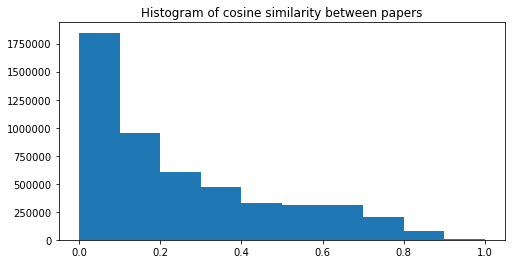

In [599]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of cosine similarity between papers")
plt.hist(distances.flatten());

In [547]:
important_words_df.head(20)

,tfidf,words
religion,0.569490,religion
religions,0.350387,religions
religious,0.272853,religious
mythology,0.099768,mythology
judaism,0.093571,judaism
sacred,0.092606,sacred
religio,0.088914,religio
culture,0.084862,culture
practices,0.083563,practices
world,0.080795,world


In [532]:
distances = np.nan_to_num(distances)

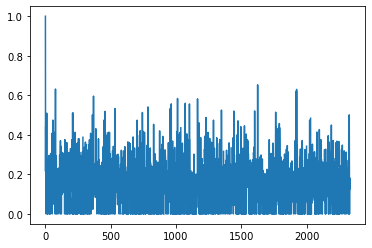

In [600]:
plt.plot(distances[0])

In [601]:
feat = np.where(distances>0.6,1,0)
np.fill_diagonal(feat, 0)

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [71]:
# building a graph using the normalized distances
graph = nx.from_numpy_matrix(adjacency_matrix)

In [72]:
# assessing the giant component size
giant_feature = max(nx.connected_component_subgraphs(graph), key=len)
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 1866 nodes and 25422 edges.


In [73]:
# getting the average clustering coefficient of our graph
nx.average_clustering(graph)

0.3443065019539001

## Exploring possible clustering in the graph

In [111]:
matrixu = MatrixUtils()

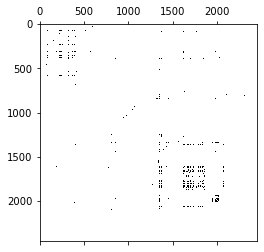

In [74]:
plt.spy(adjacency_matrix)
plt.show()

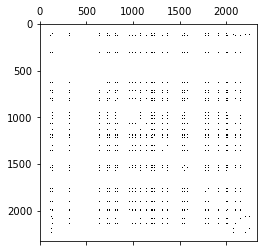

In [610]:
adjacency = matrixu.epsilon_similarity_graph(feat, sigma= 10*np.mean(feat), epsilon=0.20)
plt.spy(adjacency)
plt.show()

In [ ]:
import operator
pr = nx.pagerank(graph)
sorted_pr = sorted(pr.items(), key=operator.itemgetter(1), reverse = True)

In [ ]:
sorted_pr[:10]

## Exploring possible clustering in the graph after passing it through an ideal filter

In [300]:
# Computing the laplacian
laplacian = matrixu.compute_laplacian(adjacency, normalize=True)
lam, U = matrixu.spectral_decomposition(np.nan_to_num(laplacian))

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [181]:
alpha = 0.99 / np.max(lam)

ideal_tk =  1/(1 + alpha*lam)

In [183]:
filt = ideal_graph_filter(adjacency.tolist(),ideal_tk)

In [184]:
graph_filt = nx.from_numpy_matrix(filt)

In [ ]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(graph, **options)

In [ ]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(graph_filt, **options)

In [ ]:
giant_features = max(nx.connected_component_subgraphs(graph_filt), key = len)

In [ ]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(giant_features, **options)

In [ ]:
giant_features.nodes

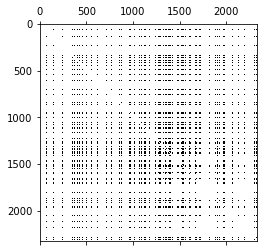

In [196]:
adjacency_filt = epsilon_similarity_graph(filt, sigma= 2*np.mean(feat), epsilon=0.60)
plt.spy(adjacency)
plt.show()

## Visualizing the graph obtained

In [78]:
visu = VisUtils()

### Laplacian Eigenmaps

In [87]:
twoD_embeddings = visu.laplacian_eigenmaps(adjacency_matrix, dim=2, sigma= 4*np.mean(adjacency_matrix), epsilon=0.40, normalize=True)

NameError: name 'squareform' is not defined

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5, 1.0, 'Graph of Wikipedia Science and Religion articles (done using Laplacian Eigenmaps)')

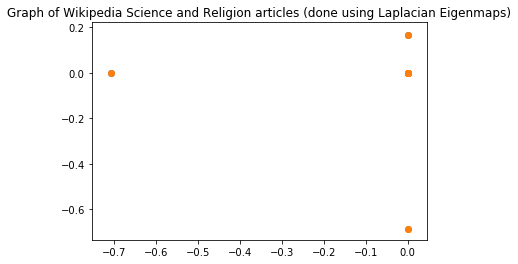

In [581]:
plt.scatter(twoD_embeddings[0:800,0], twoD_embeddings[0:800,1], label=1)
plt.scatter(twoD_embeddings[800:2650,0], twoD_embeddings[800:2650,1], label=2)
plt.title('Graph of Wikipedia Science and Religion articles (done using Laplacian Eigenmaps)')

### t-sne

In [89]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2)
x_embed = tsne.fit_transform(adjacency_matrix)

Text(0.5, 1.0, 'Graph of Wikipedia Science and Religion articles (done using tSN-E)')

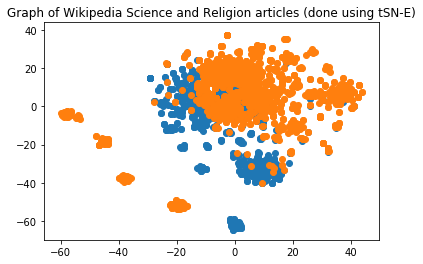

In [90]:
plt.scatter(x_embed[0:800,0], x_embed[0:800,1], label=1)
plt.scatter(x_embed[800:2650,0], x_embed[800:2650,1], label=2)
plt.title('Graph of Wikipedia Science and Religion articles (done using tSN-E)')

# III. Machine Learning

In [91]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from dgl import DGLGraph
import dgl.function as fn

np.random.seed(0)
torch.manual_seed(1)

In [92]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights)

        result = self.pol_weights[0] * feat.clone()

        for i in range(1, self._k + 1):
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

In [93]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()  # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
       
def test_articles(model, g, features, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask] 
        _, indices = torch.max(logits, dim=1)
        return indices

In [96]:
from sklearn.model_selection import train_test_split
x1, x2, y1, y2, idx1, idx2 = train_test_split(
    adjacency_matrix, labels_df['label'], range(adjacency_matrix.shape[1]), test_size=0.4)
x3, x4, y3, y4, idx3, idx4 = train_test_split(
    x2, y2, idx2, test_size=0.5)

NameError: name 'labels_df' is not defined

In [617]:
train_df = pd.DataFrame(np.column_stack((idx1, np.ones(len(idx1)).T)), columns = ['idx', 'indices'])
train_ = labels_df.merge(train_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
val_df = pd.DataFrame(np.column_stack((idx3, np.ones(len(idx3)).T)), columns = ['idx', 'indices'])
val_ = labels_df.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
test_df = pd.DataFrame(np.column_stack((idx4, np.ones(len(idx4)).T)), columns = ['idx', 'indices'])
test_ = labels_df.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)

In [618]:
features.shape

(2330, 93)

In [619]:
in_feats = features.shape[1] 
n_classes = 2
pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 100
p_dropout = 0.8
features_ = torch.FloatTensor(features) 
labels = torch.LongTensor(labels_df['label']) 
train_mask = torch.BoolTensor(train_['indices'])
val_mask = torch.BoolTensor(val_['indices'])
test_mask = torch.BoolTensor(test_['indices'])

In [620]:
model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

graph = DGLGraph(graph)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features_, labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features_, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features_, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Time(s) nan | Train Loss 0.6932 | Val Accuracy 0.4151
Epoch 00001 | Time(s) nan | Train Loss 0.7119 | Val Accuracy 0.4495
Epoch 00002 | Time(s) nan | Train Loss 0.6933 | Val Accuracy 0.3601
Epoch 00003 | Time(s) 0.0253 | Train Loss 0.6967 | Val Accuracy 0.3922
Epoch 00004 | Time(s) 0.0244 | Train Loss 0.7032 | Val Accuracy 0.3968
Epoch 00005 | Time(s) 0.0242 | Train Loss 0.7007 | Val Accuracy 0.3647
Epoch 00006 | Time(s) 0.0248 | Train Loss 0.6944 | Val Accuracy 0.5619
Epoch 00007 | Time(s) 0.0252 | Train Loss 0.6920 | Val Accuracy 0.5757
Epoch 00008 | Time(s) 0.0250 | Train Loss 0.6911 | Val Accuracy 0.6261
Epoch 00009 | Time(s) 0.0247 | Train Loss 0.6885 | Val Accuracy 0.6239
Epoch 00010 | Time(s) 0.0245 | Train Loss 0.6801 | Val Accuracy 0.6514
Epoch 00011 | Time(s) 0.0242 | Train Loss 0.6670 | Val Accuracy 0.6399
Epoch 00012 | Time(s) 0.0244 | Train Loss 0.6629 | Val Accuracy 0.6399
Epoch 00013 | Time(s) 0.0244 | Train Loss 0.6760 | Val Accuracy 0.6376
Epoch 00014 | T

In [621]:
coeff_gcn =  model.pol_weights.data.numpy()
print(coeff_gcn)

[-1.1951821   1.2388436   0.28559923 -0.38908613]


In [622]:
model

LaplacianPolynomial(
  in=93, out=2, normalization=True
  (dropout): Dropout(p=0.8, inplace=False)
)

In [623]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    # Your code here
    V = np.vander(lam, len(coeff), increasing=True)
    return V@coeff

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Spectral response (db)')

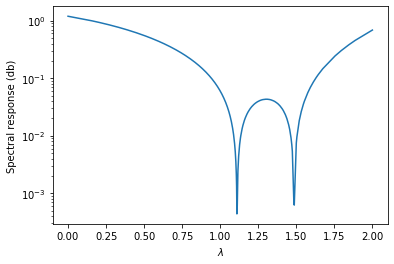

In [624]:
plt.semilogy(lam, np.abs(polynomial_graph_filter_response(coeff_gcn, lam)))
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response (db)')

In [625]:
list_articles = ["God", "Network Science", "Jesus", "Quantic physics"]
test_df = take_words(list_articles, is_title = True)

0


In [626]:
test = make_features(test_df)
features_final = np.concatenate((features, test))

words,abrahamic,ancient,antiquity,aristotelian,aristotle,asia,bacon,bce,belief,beliefs,...,study,superstition,term,theories,theory,things,used,western,word,world
article,,,,,,,,,,,,,,,,,,,,,
God,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
Jesus,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
Network Science,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
Quantic physics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [627]:
distances = np.array([[(np.sum((features_final[i,:]-features_final[j,:])**2)) for i in range(0,features_final.shape[0]) ] for j in range(0,features_final.shape[0])]).reshape(features_final.shape[0],-1)
feat = distances/np.max(distances)
np.fill_diagonal(feat, 0)
graph = nx.from_numpy_array(feat)
graph = DGLGraph(graph)

In [628]:
features_ = torch.FloatTensor(features_final)

In [629]:
mask1 = np.zeros((len(features)))
mask2 = np.ones((len(test)))
mask = np.concatenate((mask1,mask2))
mask = torch.BoolTensor(mask)

In [630]:
test_articles(model, graph, features_, mask)

tensor([1, 1, 1, 1])

In [389]:
model.pol_weights

Parameter containing:
tensor([-0.1174,  0.0572,  0.0553,  0.0574], requires_grad=True)

In [390]:
model.logr_weights

Parameter containing:
tensor([[ 1.2907, -1.2909],
        [-1.0584,  1.0577],
        [ 0.0989, -0.0988],
        ...,
        [-0.2613,  0.2613],
        [-0.9524,  0.9525],
        [ 0.9983, -0.9981]], requires_grad=True)

## Cheeger constant

In [ ]:
matrixu()

## Heuristic Eigengaps

In [120]:
laplacian = matrixu.compute_laplacian(adjacency_matrix, normalize = False)
eigenvalues, eigenvectors = matrixu.spectral_decomposition(laplacian)

Text(0.5, 1.0, 'Eigenvalues $L_{comb}$')

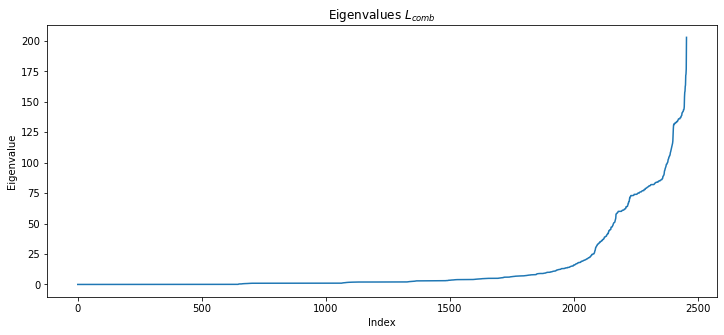

In [121]:
plt.figure(figsize=(12,5))
plt.plot(eigenvalues)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')

In [128]:
eigenvalues[2000]

(15.948726685937839-0.28183982063015883j)